In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# leer archivo csv

strava_edu = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_eduardo_sanchez.csv")
# ver las primeras filas del dataframe

strava_edu.head()


,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Recovery,With Pet,Competition,Long Run,For a Cause,Media
0,7814133660,"Sep 15, 2022, 7:03:46 PM",Carrera nocturna,Run,NaN,1791,5.46,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7845849909,"Sep 21, 2022, 6:31:03 PM",Carrera nocturna,Run,NaN,2174,5.07,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8820849555,"Apr 2, 2023, 4:47:15 PM",Carrera de noche,Run,"Mal,\nRodilla",1083,3.03,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11329721146,"May 4, 2024, 10:05:53 AM",Lunch Ride,Ride,NaN,3893,16.62,184.0,94.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11343506467,"May 6, 2024, 7:44:00 AM",Morning Walk,Walk,NaN,1219,1.97,129.0,4.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# informacion del dataframe

strava_edu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 99 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Activity ID                   134 non-null    int64  
 1   Activity Date                 134 non-null    object 
 2   Activity Name                 134 non-null    object 
 3   Activity Type                 134 non-null    object 
 4   Activity Description          31 non-null     object 
 5   Elapsed Time                  134 non-null    int64  
 6   Distance                      134 non-null    float64
 7   Max Heart Rate                131 non-null    float64
 8   Relative Effort               131 non-null    float64
 9   Commute                       134 non-null    bool   
 10  Activity Private Note         0 non-null      float64
 11  Activity Gear                 0 non-null      float64
 12  Filename                      134 non-null    object 
 13  Athle

In [5]:
def limpiar_strava(df):
    # Renombrar columnas 
    df = df.rename(columns={
        'Activity Date': 'activity_date',
        'Activity Type': 'activity_type',
        'Activity Name': 'activity_name',
        'Distance': 'distance',
        'Elapsed Time': 'elapsed_time',
        'Average Speed': 'average_speed',
        'Elevation Gain': 'elevation_gain',
        'Average Heart Rate': 'avg_heart_rate',
        'Max Heart Rate': 'max_heart_rate',
        'Calories': 'calories',
        'Average Cadence': 'avg_cadence',
        'Activity ID': 'activity_id',
        'Filename': 'filename'
    })

    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Run')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_edu)

C:\Users\eduar\AppData\Local\Temp\ipykernel_38956\2759599616.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')


In [6]:
# añadir columna de usuario

strava_limpio['user'] = 'Eduardo Sánchez'

In [7]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_eduardo_sanchez_limpio.csv", index=False)

In [8]:
strava_limpio.tail(20)

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
114,15109459890,2025-07-14 10:50:53,Run,5.59,00:29:59,5.22,3.164706,82.811592,157.742477,183.0,358.0,Eduardo Sánchez
115,15147756291,2025-07-17 18:44:31,Run,5.12,00:29:09,5.42,11.788889,81.805382,164.871201,180.0,373.0,Eduardo Sánchez
116,15161625387,2025-07-19 05:59:00,Run,8.01,00:39:05,4.53,23.162720,84.024117,176.808487,190.0,555.0,Eduardo Sánchez
117,15183554491,2025-07-21 06:12:39,Run,6.01,00:33:16,5.32,40.558399,83.147522,156.844818,182.0,394.0,Eduardo Sánchez
118,15195955846,2025-07-22 06:38:59,Run,30.14,03:47:13,7.32,74.365524,82.118080,148.813690,166.0,1036.0,Eduardo Sánchez
119,15228083885,2025-07-25 05:34:08,Run,6.01,00:27:43,4.37,0.000000,84.244736,154.699936,164.0,310.0,Eduardo Sánchez
120,15299983043,2025-07-30 18:33:56,Run,4.89,00:25:14,5.10,56.387539,82.680321,164.663147,182.0,323.0,Eduardo Sánchez
121,15307992092,2025-07-31 17:40:15,Run,5.02,00:27:39,5.30,21.030392,82.127769,170.543030,184.0,345.0,Eduardo Sánchez
122,15369473063,2025-08-06 18:28:08,Run,3.80,00:16:19,4.18,34.596588,83.875900,161.845123,196.0,203.0,Eduardo Sánchez
123,15391206030,2025-08-08 18:12:40,Run,4.41,00:20:02,4.33,67.223930,84.094086,195.711914,202.0,331.0,Eduardo Sánchez


## Ejercicio función EDA

Esta función como mínimo debe hacer:
- Tablas o gráficos para ver qué variables tienen nulos.
- Principales estadísticos de variables continuas
- Distribución de variables continuas
- Representación gráfica de las variables categóricas (por ej. pie chart)
- Mapa de correlaciones

## Funcion EDA CSV limpio

No hay valores nulos en las variables seleccionadas.
Estadísticos de variables seleccionadas:
       distance_km  pace_formatted     calories
count    99.000000       99.000000    99.000000
mean      6.916263        5.503434   443.393939
std       4.026147        1.232736   228.407522
min       0.470000        4.120000    26.000000
25%       5.000000        5.065000   310.500000
50%       6.010000        5.300000   392.000000
75%       8.890000        5.515000   612.000000
max      30.140000       13.200000  1451.000000


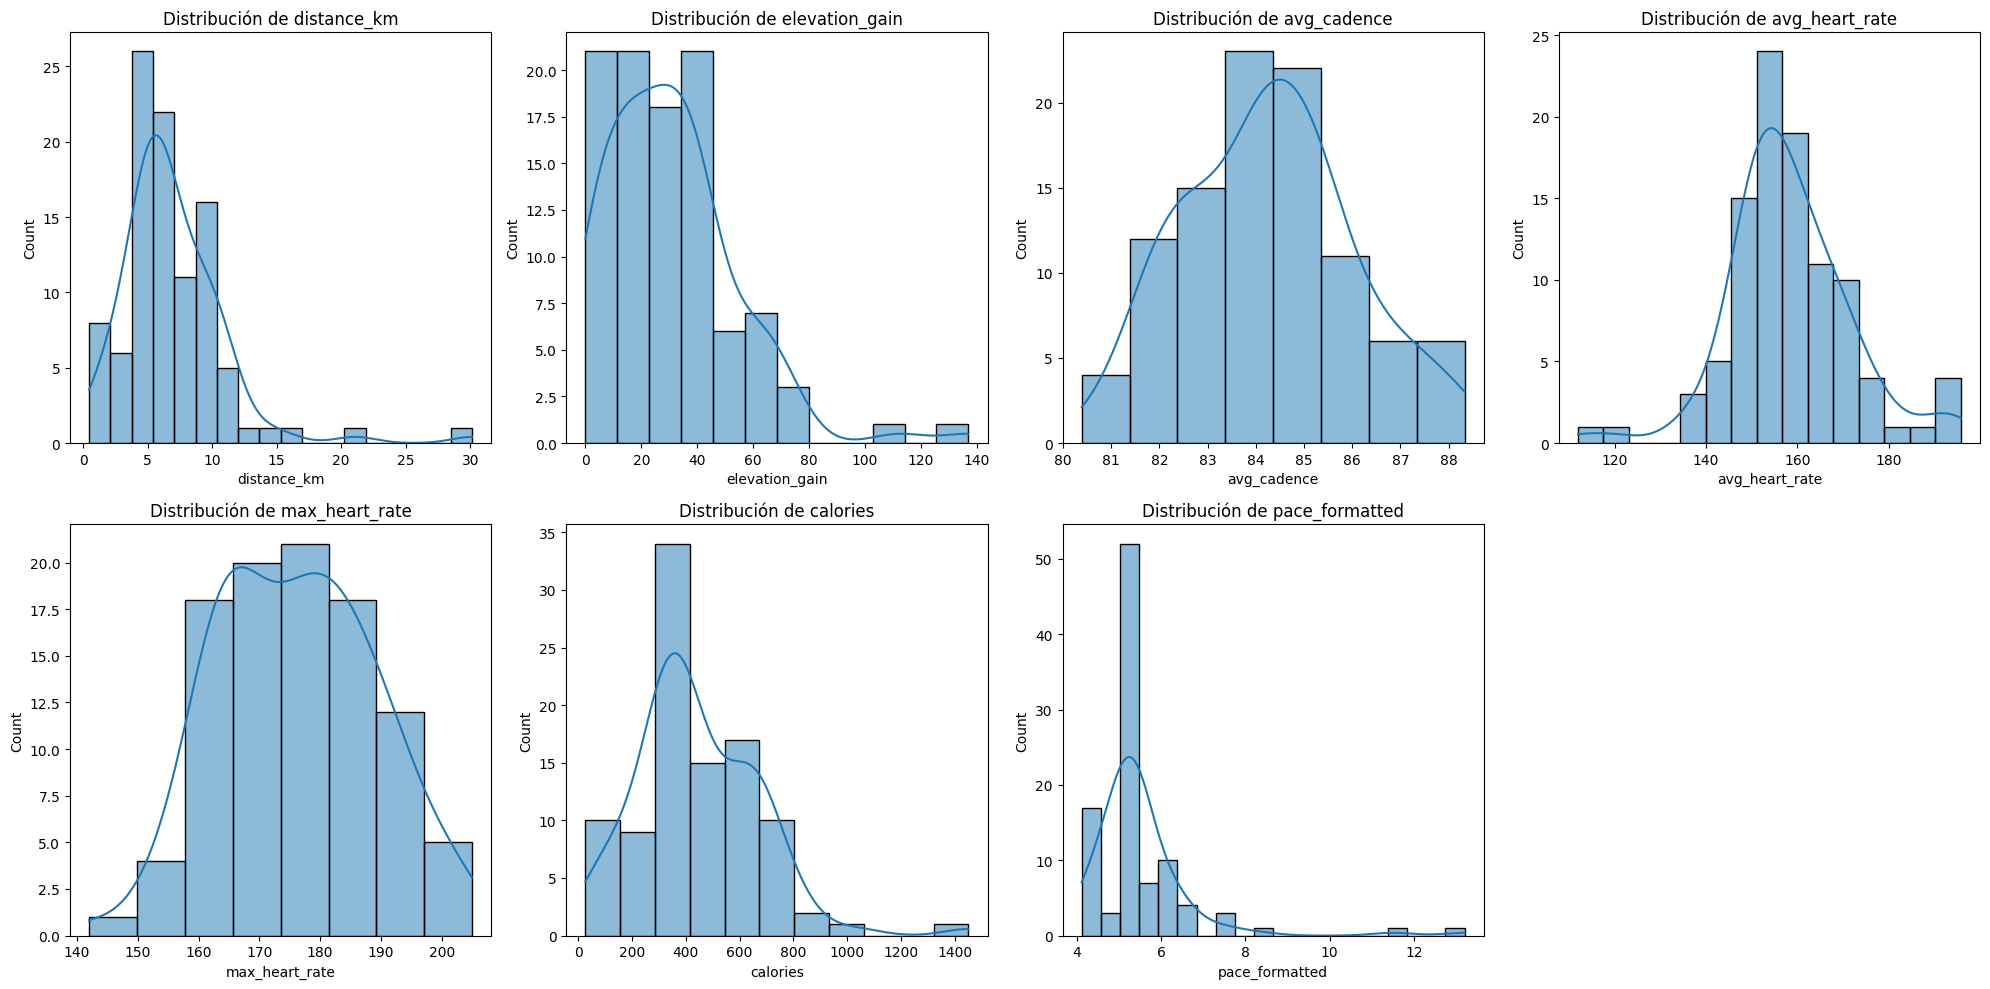

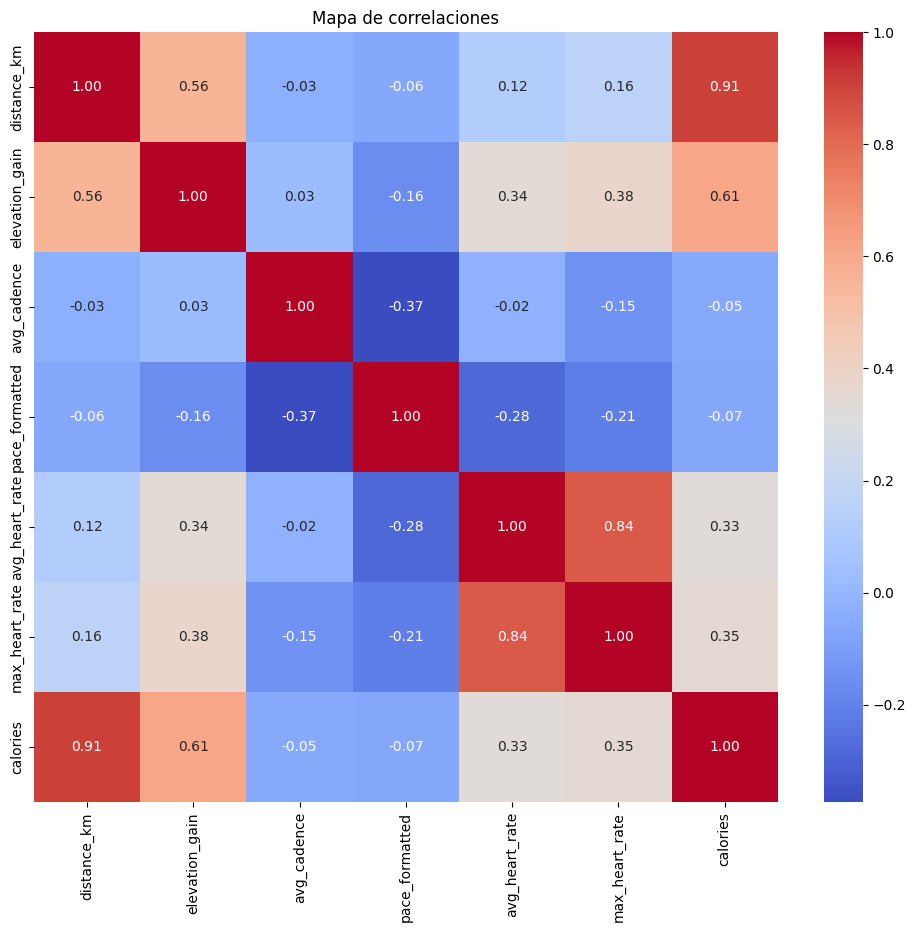

In [9]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)

## Funcion EDA con el CSV original

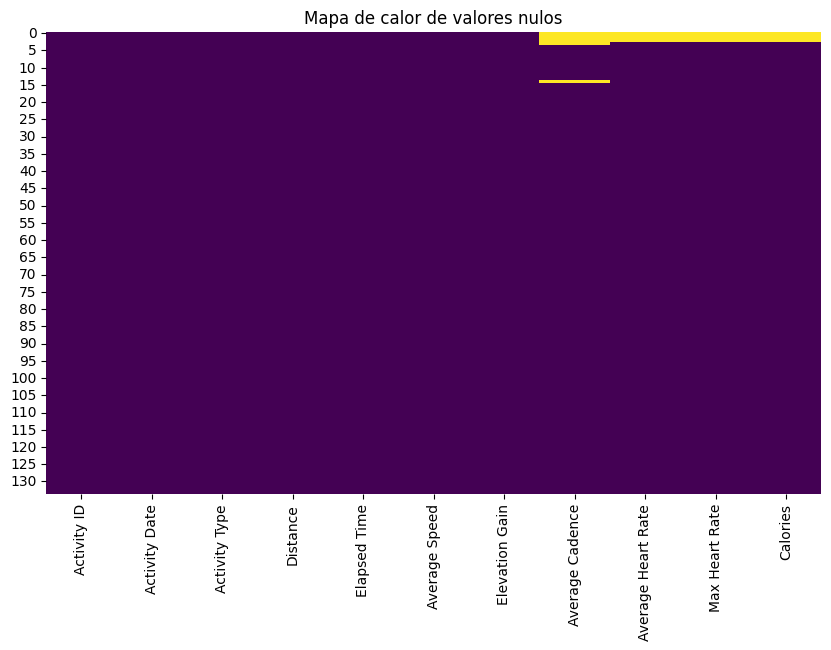

Estadísticos de variables seleccionadas:
         Distance     Calories
count  134.000000   131.000000
mean     5.893134   391.473282
std      4.343850   262.864204
min      0.000000    18.000000
25%      2.992500   206.000000
50%      5.385000   358.000000
75%      7.922500   598.000000
max     30.140000  1451.000000


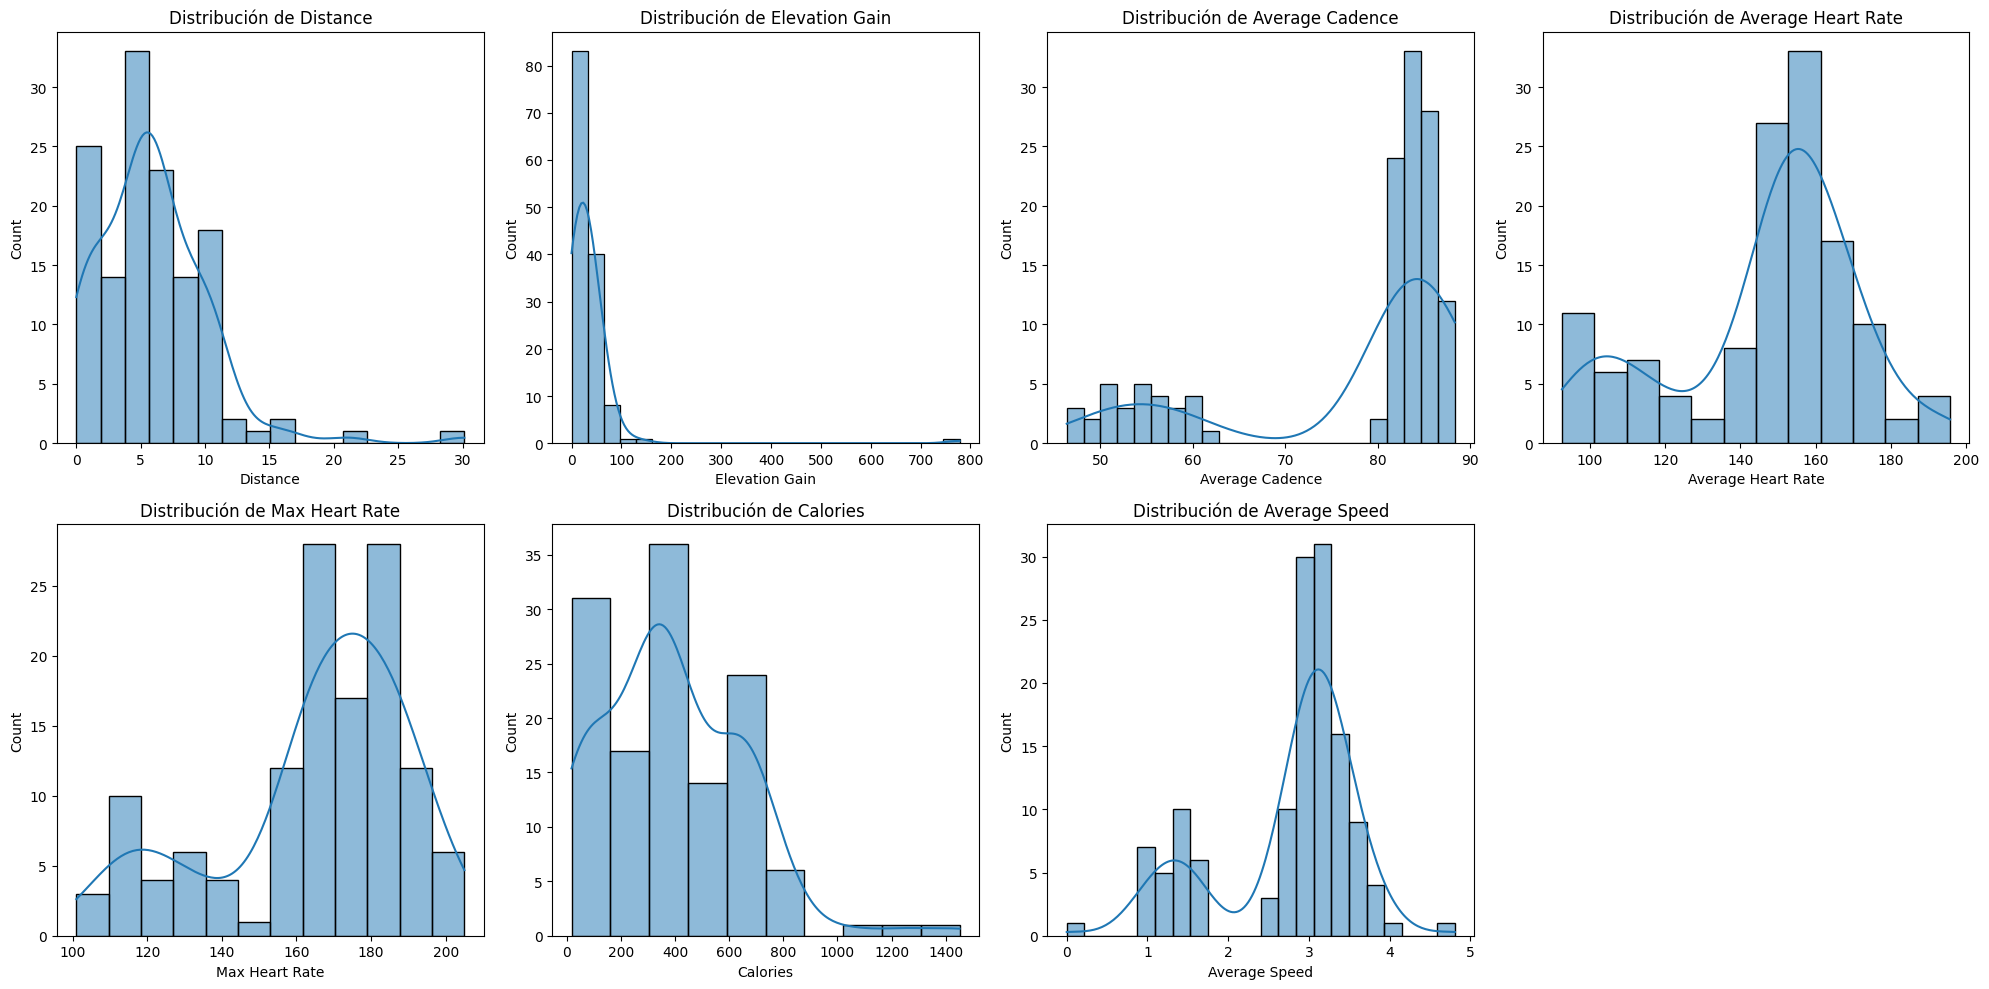

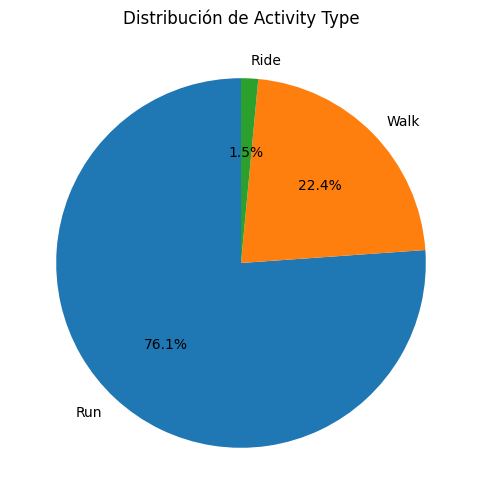

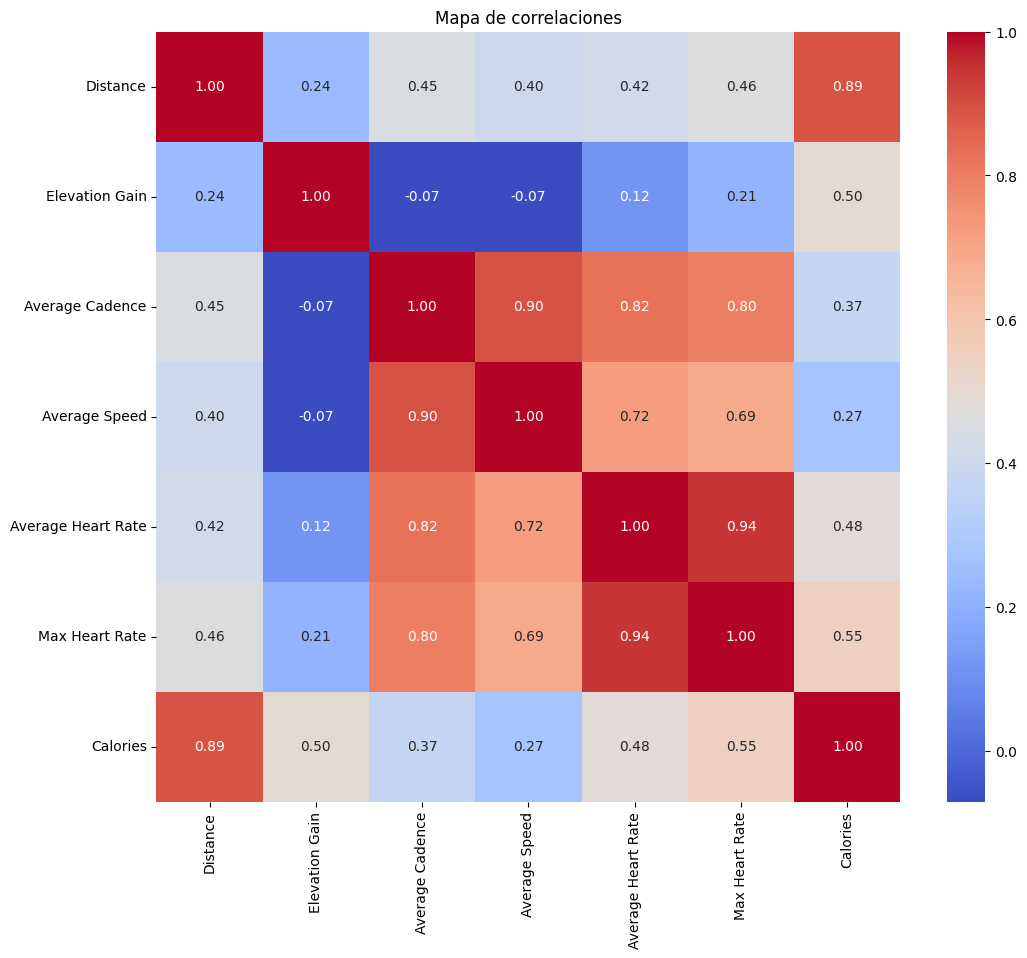

In [10]:
def EDA_strava_edu(data):
    # Seleccionar solo las columnas relevantes del dataset original
    columnas = [
        'Activity ID', 'Activity Date', 'Activity Type',
        'Distance', 'Elapsed Time',
        'Average Speed', 'Elevation Gain', 'Average Cadence',
        'Average Heart Rate', 'Max Heart Rate', 'Calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['Distance', 'Calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['Distance', 'Elevation Gain', 'Average Cadence', 'Average Heart Rate', 'Max Heart Rate', 'Calories', 'Average Speed']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()
    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    # Representación gráfica de las variables categóricas (pie chart)
    cat_vars = ['Activity Type']
    for var in cat_vars:
        plt.figure(figsize=(6,6))
        data[var].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title(f'Distribución de {var}')
        plt.ylabel('')
        plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['Distance', 'Elevation Gain', 'Average Cadence', 'Average Speed', 'Average Heart Rate', 'Max Heart Rate', 'Calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA_strava_edu(strava_edu)